In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as data_sets
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
import numpy as np
import sklearn.metrics as sk

import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torchvision.datasets as data_sets
mnist_train_data=data_sets.MNIST('mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_test_data=data_sets.MNIST('mnist', train=False, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw




Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw

Processing...
Done!


In [3]:
developement_size=18000
mnist_train_data, mnist_developement_set = random_split(mnist_train_data, [len(mnist_train_data) - developement_size, developement_size])

In [4]:
print('Train Dataset :', len(mnist_train_data), "\nValidation Dataset:" ,len(mnist_developement_set))

Train Dataset : 42000 
Validation Dataset: 18000


In [5]:
batch_size = 128

In [6]:
train_data_loader = DataLoader(dataset=mnist_train_data,batch_size= batch_size,num_workers=2,pin_memory=True,shuffle=True)
developement_data_loader = DataLoader(dataset = mnist_developement_set,batch_size = batch_size*2,num_workers=2,pin_memory=True)
test_data_loader = DataLoader(dataset=mnist_test_data,batch_size= batch_size,num_workers=2,pin_memory=True,shuffle=False)

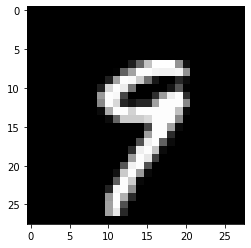

In [7]:
plt.imshow(mnist_train_data[0][0][0], cmap="gray")

Shape of Images: torch.Size([128, 1, 28, 28])


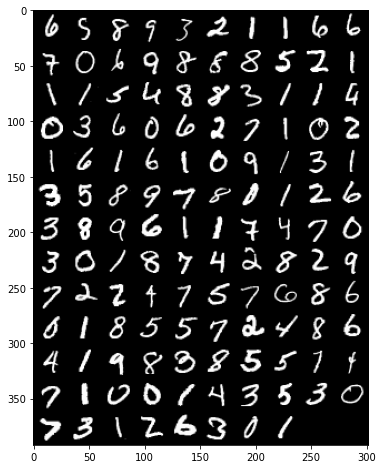

In [8]:
iterobj = iter(train_data_loader)
images, labels = iterobj.next()
print('Shape of Images:', images.shape)
plt.figure(figsize=(16,8))
plt.imshow(make_grid(images, nrow=10).permute((1, 2, 0)))

In [9]:
class CNN_with_optimizer(nn.Module):
    def __init__(self):
        super(CNN_with_optimizer, self).__init__() 
        self.conv1 = nn.Conv2d(in_channels=1,out_channels= 32,kernel_size=5,stride=1,padding=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,stride=1,padding=2)    
        self.relu2 = nn.ReLU()  
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        nn.init.xavier_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(1000, 10)
        nn.init.xavier_normal_(self.fc2.weight)

    def forward(self, batch_data):
        batch_data = self.conv1(batch_data)
        batch_data = self.relu1(batch_data)
        batch_data = self.maxpool1(batch_data)
       
        batch_data = self.conv2(batch_data)
        batch_data = self.relu2(batch_data)
        batch_data = self.maxpool1(batch_data)
      
        batch_data = batch_data.reshape(batch_data.size(0), -1)
    
        batch_data = self.fc1(batch_data)
        batch_data = self.fc2(batch_data)
        return batch_data
    
    def train_each_batch(self, images, labels):
        result = self(images)
        loss = Loss(result, labels)
        return loss

    def develope_each_batch(self, images, labels):
        # images =  batch[0]
        # labels = batch[1]
        result = self(images)                   
        loss = Loss(result, labels)
        acc = accuracy(result, labels)      
        return {'loss_at_end_of_batch': loss, 'acc_at_end_of_batch': acc}
      
    def develope_at_end_of_epoch(self, results):
        losses_at_end_of_batch = [x['loss_at_end_of_batch'] for x in results]
        loss_at_end_of_epoch = torch.stack(losses_at_end_of_batch).mean()  
        accs_at_each_batch = [x['acc_at_end_of_batch'] for x in results]
        acc_at_end_of_epoch = torch.stack(accs_at_each_batch).mean() 
        return {'loss_at_end_of_epoch': loss_at_end_of_epoch.item(), 'acc_at_end_of_epoch': acc_at_end_of_epoch.item()}

    def display_metrics_at_end_of_epoch(self, epoch, result):
        print("acc_at_end_of_epoch: {:.4f}, loss_at_end_of_epoch: {:.4f}".format(result['acc_at_end_of_epoch'], result['loss_at_end_of_epoch']))

In [10]:
def accuracy(results, labels):
    _, predictions = torch.max(results, dim=1)
    return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

In [11]:
def develope(network, developement_data_loader):
    results = [network.develope_each_batch(images, labels) for j, (images, labels) in enumerate(developement_data_loader)]
    return network.develope_at_end_of_epoch(results)

In [12]:
network=CNN_with_optimizer()

In [13]:
# optimizer RMSprop

In [14]:
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(network.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [15]:
def train(epochs, model, train_data_loader, developement_data_loader, optimizer):    
    epoch_metrics = []
    for epoch in range(epochs): 
        lr = scheduler.step()
        print('Epoch:', epoch,'Learning rate:', scheduler.get_lr())
        for j,(images, labels) in enumerate(train_data_loader):
            loss = model.train_each_batch(images, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = develope(model, developement_data_loader)
        model.display_metrics_at_end_of_epoch(epoch, result)
        epoch_metrics.append(result)
        print("\n")
    return epoch_metrics

In [16]:
metrics_history_first = train(10, network, train_data_loader, developement_data_loader, optimizer)

Epoch: 0 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9375, loss_at_end_of_epoch: 0.2148


Epoch: 1 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9500, loss_at_end_of_epoch: 0.1659


Epoch: 2 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9555, loss_at_end_of_epoch: 0.1757


Epoch: 3 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9656, loss_at_end_of_epoch: 0.1227


Epoch: 4 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9392, loss_at_end_of_epoch: 0.2314


Epoch: 5 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9608, loss_at_end_of_epoch: 0.1360


Epoch: 6 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9537, loss_at_end_of_epoch: 0.1703


Epoch: 7 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9597, loss_at_end_of_epoch: 0.1535


Epoch: 8 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9626, loss_at_end_of_epoch: 0.1374


Epoch: 9 Learning rate: [1e-05]
acc_at_end_of_epoch: 0.9765, loss_at_end_of_epoch: 0.0816




In [18]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
else:
    device=torch.device("cpu")
print(device)

cpu


In [19]:
def test(network, test_data_loader):
  network.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    actuals = []
    predictions = []
    for images, labels in test_data_loader:
        images = Variable(images)
        results = network(images)
        prediction = results.argmax(dim=1, keepdim=True)
        actuals.extend(labels.view_as(prediction))
        predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

#     return (correct / total) * 100

In [20]:
# acc_of_test=test(network, test_data_loader)
print("After Test : ")
# print("Accuracy of the model :",acc_of_test)
actuals, predictions = test(network, test_data_loader)
print('Confusion matrix:')
print(sk.confusion_matrix(actuals, predictions))

After Test : 
Confusion matrix:
[[ 972    1    0    1    0    0    4    1    1    0]
 [   3 1117    1    0    0    4    3    3    4    0]
 [   3    1 1006    6    0    0    1    8    7    0]
 [   0    0    1  999    0    5    0    3    2    0]
 [   0    3    2    0  959    0    2    1    1   14]
 [   0    1    0    7    0  877    2    0    4    1]
 [   5    4    1    0    4    4  938    0    2    0]
 [   0    2    7    4    0    0    0 1007    1    7]
 [   5    1    3    3    2    1    1    3  949    6]
 [   2    2    1    3    6    5    0    6    3  981]]


In [21]:
print('Accuracy score: %f' % sk.accuracy_score(actuals, predictions))

Accuracy score: 0.980500


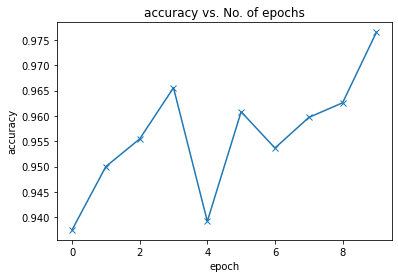

In [22]:
accs=[x['acc_at_end_of_epoch'] for x in metrics_history_first]
plt.plot(accs, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs. No. of epochs');

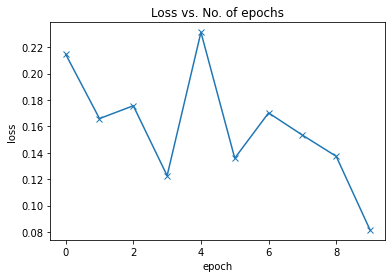

In [23]:
losses = [x['loss_at_end_of_epoch'] for x in metrics_history_first]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [24]:
# optimizer = adam

In [25]:
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr= 0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [26]:
metrics_history_second = train(10, network, train_data_loader, developement_data_loader, optimizer)

Epoch: 0 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9790, loss_at_end_of_epoch: 0.0745


Epoch: 1 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9789, loss_at_end_of_epoch: 0.0755


Epoch: 2 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9787, loss_at_end_of_epoch: 0.0757


Epoch: 3 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9783, loss_at_end_of_epoch: 0.0796


Epoch: 4 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9783, loss_at_end_of_epoch: 0.0871


Epoch: 5 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9785, loss_at_end_of_epoch: 0.0811


Epoch: 6 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9785, loss_at_end_of_epoch: 0.0838


Epoch: 7 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9785, loss_at_end_of_epoch: 0.0878


Epoch: 8 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9791, loss_at_end_of_epoch: 0.0862


Epoch: 9 Learning rate: [1e-05]
acc_at_end_of_epoch: 0.9800, loss_at_end_of_epoch: 0.0858




In [27]:
# acc_of_test=test(network, test_data_loader)
print("After Test : ")
# print("Accuracy of the model :",acc_of_test)
actuals, predictions = test(network, test_data_loader)
print('Confusion matrix:')
print(sk.confusion_matrix(actuals, predictions))

After Test : 
Confusion matrix:
[[ 972    1    1    2    0    0    3    0    1    0]
 [   0 1124    2    0    0    2    1    2    4    0]
 [   3    5 1019    1    0    0    0    2    2    0]
 [   0    0    4  994    0    5    0    5    2    0]
 [   0    2    4    0  963    0    3    0    1    9]
 [   2    0    0    5    0  880    1    1    2    1]
 [   7    2    2    0    2    4  938    0    3    0]
 [   0    3    9    2    0    0    0 1010    1    3]
 [   3    1    4    2    3    1    1    2  952    5]
 [   2    3    1    0    3    3    0    6    5  986]]


In [28]:
print('Accuracy score: %f' % sk.accuracy_score(actuals, predictions))

Accuracy score: 0.983800


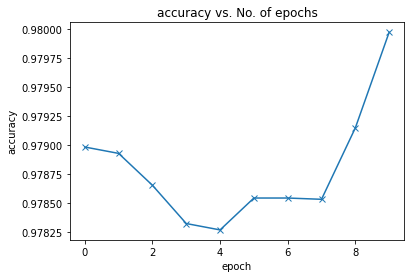

In [29]:
accs=[x['acc_at_end_of_epoch'] for x in metrics_history_second]
plt.plot(accs, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs. No. of epochs');

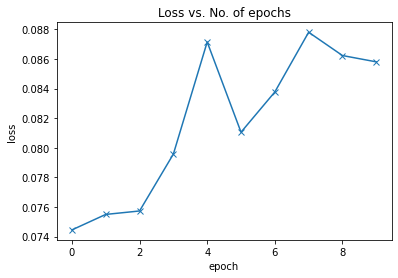

In [30]:
losses = [x['loss_at_end_of_epoch'] for x in metrics_history_second]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [31]:
# optimizer nestorov

In [32]:
Loss = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(network.parameters(), lr= 0.001)
optimizer = torch.optim.SGD(network.parameters(), lr=0.001, momentum=0.9, nesterov = True)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [33]:
metrics_history_third = train(10, network, train_data_loader, developement_data_loader, optimizer)

Epoch: 0 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9794, loss_at_end_of_epoch: 0.0877


Epoch: 1 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9799, loss_at_end_of_epoch: 0.0893


Epoch: 2 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9795, loss_at_end_of_epoch: 0.0895


Epoch: 3 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9793, loss_at_end_of_epoch: 0.0892


Epoch: 4 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9793, loss_at_end_of_epoch: 0.0909


Epoch: 5 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9794, loss_at_end_of_epoch: 0.0909


Epoch: 6 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9795, loss_at_end_of_epoch: 0.0903


Epoch: 7 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9794, loss_at_end_of_epoch: 0.0916


Epoch: 8 Learning rate: [0.001]
acc_at_end_of_epoch: 0.9791, loss_at_end_of_epoch: 0.0923


Epoch: 9 Learning rate: [1e-05]
acc_at_end_of_epoch: 0.9792, loss_at_end_of_epoch: 0.0909




In [34]:
# acc_of_test=test(network, test_data_loader)
print("After Test : ")
# print("Accuracy of the model :",acc_of_test)
actuals, predictions = test(network, test_data_loader)
print('Confusion matrix:')
print(sk.confusion_matrix(actuals, predictions))

After Test : 
Confusion matrix:
[[ 969    1    1    2    0    0    4    0    2    1]
 [   0 1125    2    0    0    2    1    2    3    0]
 [   3    5 1019    1    0    0    0    2    2    0]
 [   0    0    4  995    0    5    0    5    1    0]
 [   0    2    4    0  960    0    3    0    2   11]
 [   2    0    0    5    0  880    1    1    2    1]
 [   7    2    2    0    2    4  939    0    2    0]
 [   0    3    7    2    0    0    0 1011    1    4]
 [   3    1    4    2    3    1    1    2  952    5]
 [   2    1    1    0    7    3    0    6    5  984]]


In [35]:
print('Accuracy score: %f' % sk.accuracy_score(actuals, predictions))

Accuracy score: 0.983400


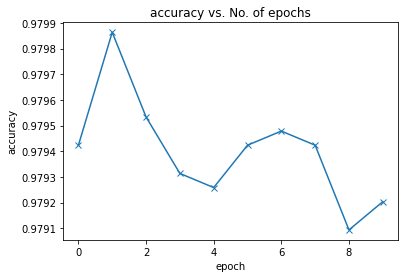

In [36]:
accs=[x['acc_at_end_of_epoch'] for x in metrics_history_third]
plt.plot(accs, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs. No. of epochs');

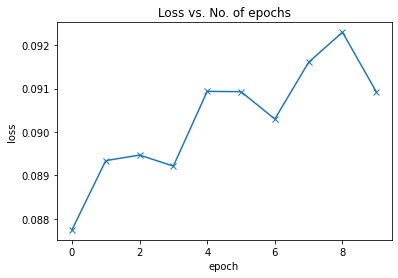

In [37]:
losses = [x['loss_at_end_of_epoch'] for x in metrics_history_third]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

baseline- optimizers 


we have implemented 3 optimizers

RMSprop uses an adaptive learning rate instead of treating the learning rate as a hyperparameter. This means that the learning rate changes over time.

Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.

Nestorov is a technique where the gradient for  a time step, also takes into account the estimated gradient for the next time step, which gives a better idea whether to slow down or not.

We have started the learning rate from 0.001 and implemented the same schedular, as per the above results, while the optimizers seems to fit the data decently, adam optimizer performs the best followed RMSprop, and then nestorov. 

The results obtained would have been higher if run with a better learning rate and more epochs, but due to hardware limitation we couldnt do so, but based on the results obtained we may conclude that adam optimizer by its technique and performance is the most reliable optimizer for CNN. 